# Basic example
Let's use EOReader for the first time.

## Imports


In [1]:
import os

# EOReader
from eoreader.reader import Reader
from eoreader.bands import GREEN, NDVI, CLOUDS

## Data

First of all, we need some satellite data. 
Let's open a `Sentinel-2` product.

In [2]:
path = os.path.join("/home", "data", "DATA", "PRODS", "S2", "PB 02.07+", "S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749.SAFE")

## Create the Reader
First, create the `Reader` object.
This object will automatically detect the type of constellation of your product.
It relies on the internal composition of the product (usually the presence of the metadata file), so please do not remove them.

*The `Reader` is a singleton that should be called only once.*
*It can be used several times to open all your satellite products.*

No need to extract the product here: archived `Sentinel-2` are handled by EOReader.

In [3]:
reader = Reader()

## Open the product

The reader is used to open your product, just call the `open` function.

In [4]:
prod = reader.open(path)
prod

eoreader.S2Product 'S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749'
Attributes:
	condensed_name: 20200114T065229_S2_T40REQ_L2A_094749
	path: /home/data/DATA/PRODS/S2/PB 02.07+/S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T094749.SAFE
	constellation: Sentinel-2
	sensor type: Optical
	product type: MSIL2A
	default pixel size: 10.0
	default resolution: 10.0
	acquisition datetime: 2020-01-14T06:52:29
	band mapping:
		COASTAL_AEROSOL: 01
		BLUE: 02
		GREEN: 03
		RED: 04
		VEGETATION_RED_EDGE_1: 05
		VEGETATION_RED_EDGE_2: 06
		VEGETATION_RED_EDGE_3: 07
		NIR: 08
		NARROW_NIR: 8A
		WATER_VAPOUR: 09
		SWIR_1: 11
		SWIR_2: 12
	needs extraction: False
	cloud cover: 63.86422
	tile name: T40REQ

## Load

Just load easily some bands and index. The `load` function outputs a dictionary of `xarray.DataArray`.

The bands can be called by their ID, name or mapped name.
For example, for Sentinel-3 OLCI you can use `7`, `Oa07` or `YELLOW`. For Landsat-8, you can use `BLUE` or `2`.

In [5]:
# Load those bands as a xarray.Dataset
band_ds = prod.load([GREEN, NDVI, CLOUDS])
band_ds

<xarray.Dataset>
Dimensions:                  (x: 10980, y: 10980, band: 1)
Coordinates:
  * x                        (x) float64 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                        (y) float64 3e+06 3e+06 3e+06 ... 2.89e+06 2.89e+06
  * band                     (band) int64 1
    spatial_ref              int64 0
Data variables:
    SpectralBandNames.GREEN  (band, y, x) float32 0.1034 0.1134 ... nan nan
    NDVI                     (band, y, x) float32 0.2816 0.2359 ... nan nan
    CloudsBandNames.CLOUDS   (band, y, x) float32 0.0 0.0 0.0 ... nan nan nan
Attributes:
    long_name:         GREEN NDVI CLOUDS
    constellation:     Sentinel-2
    constellation_id:  S2
    product_path:      /home/data/DATA/PRODS/S2/PB 02.07+/S2B_MSIL2A_20200114...
    product_name:      S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T...
    product_filename:  S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T...
    instrument:        MSI
    product_type:      MSIL2A
    acquisition_date:  20200114T065229
    condensed_name:    20200114T065229_S2_T40REQ_L2A_094749
    orbit_direction:   DESCENDING
    cloud_cover:       63.86422

In [6]:
# Load individual bands (as xarray.DataArray)
green = band_ds[GREEN]
ndvi = band_ds[NDVI]
clouds = band_ds[CLOUDS]

green

<xarray.DataArray <SpectralBandNames.GREEN: 'GREEN'> (band: 1, y: 10980,
                                                      x: 10980)>
array([[[0.1034, 0.1134, 0.1064, ...,    nan,    nan,    nan],
        [0.0969, 0.0895, 0.1094, ...,    nan,    nan,    nan],
        [0.1132, 0.0959, 0.1082, ...,    nan,    nan,    nan],
        ...,
        [1.488 , 1.4416, 1.3888, ...,    nan,    nan,    nan],
        [1.468 , 1.4472, 1.4072, ...,    nan,    nan,    nan],
        [1.4168, 1.4072, 1.4   , ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
  * y            (y) float64 3e+06 3e+06 3e+06 ... 2.89e+06 2.89e+06 2.89e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes: (12/13)
    long_name:         GREEN
    constellation:     Sentinel-2
    constellation_id:  S2
    product_path:      /home/data/DATA/PRODS/S2/PB 02.07+/S2B_MSIL2A_20200114...
    product_name:      S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T...
    product_filename:  S2B_MSIL2A_20200114T065229_N0213_R020_T40REQ_20200114T...
    ...                ...
    product_type:      MSIL2A
    acquisition_date:  20200114T065229
    condensed_name:    20200114T065229_S2_T40REQ_L2A_094749
    orbit_direction:   DESCENDING
    radiometry:        reflectance
    cloud_cover:       63.86422

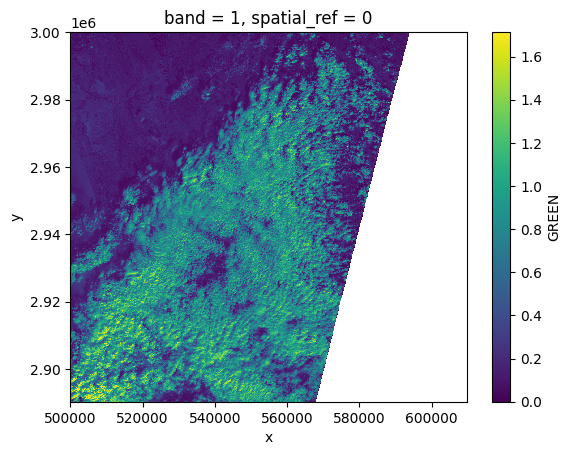

In [7]:
# Plot a subsampled version
green[:, ::10, ::10].plot()

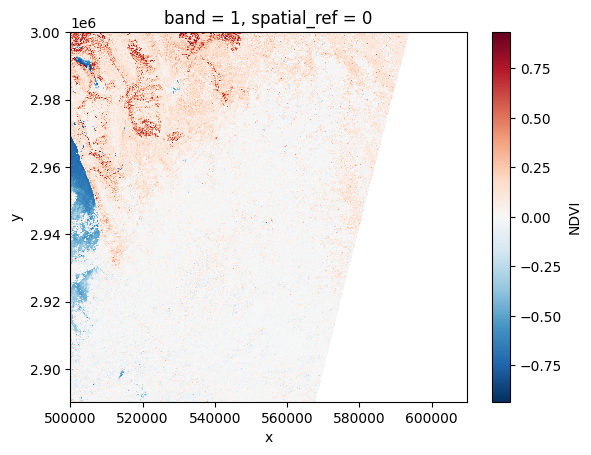

In [8]:
# Plot a subsampled version
ndvi[:, ::10, ::10].plot()

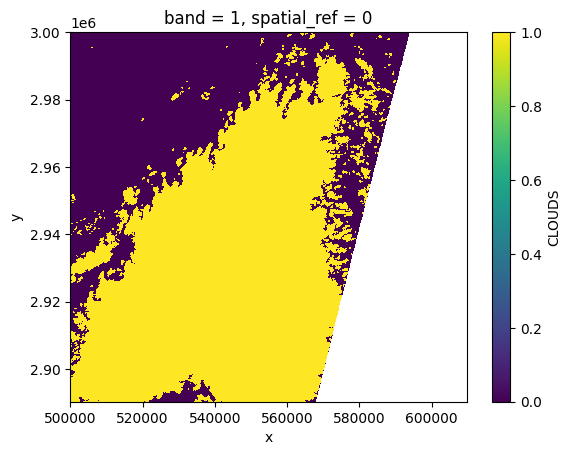

In [9]:
# Plot a subsampled version
clouds[:, ::10, ::10].plot()